# ISYE-6740 - Group Project - Feature Selection Analysis

__Objective:__ Quickly explore the impact of modeling with just the "meaningful" columns from the PCA data.

## Import Packages And Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import joblib

In [3]:
final_df = pd.read_csv('Pnuemonia Images PCA Reduced.csv')
final_df.replace({'normal':0, 'virus': 1, 'bacteria': 2},inplace=True)

In [4]:
feature_selection_cols = ['pca1', 'pca2', 'pca2', 'pca4', 'pca9']
X_train = final_df[final_df['set']=='train'][feature_selection_cols].to_numpy()
X_test  = final_df[final_df['set']=='test'][feature_selection_cols].to_numpy()
X_val  = final_df[final_df['set']=='validate'][feature_selection_cols].to_numpy()

In [6]:
y_train = final_df['y'][final_df['set']=='train'].to_numpy()
y_test = final_df['y'][final_df['set']=='test'].to_numpy()
y_val = final_df['y'][final_df['set']=='validate'].to_numpy()

## Default Model Development

### Define Models And Fit

In [7]:
#making an instance of each algorithm
knn = KNeighborsClassifier(n_neighbors = 10)
log_reg  = LogisticRegression()
dtc  = DecisionTreeClassifier()
rfc = RandomForestClassifier()
svm = SVC()
xgb = XGBClassifier()

In [8]:
#fitting each model using X_train and y_train
knn.fit(X_train, y_train)
log_reg.fit(X_train, y_train)
dtc.fit(X_train, y_train)
rfc.fit(X_train, y_train)
svm.fit(X_train, y_train)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [9]:
#scoring each model
print('KNN accuracy score is: ' + str(knn.score(X_test, y_test)))
print('Logistic Regression accuracy score is: ' + str(log_reg.score(X_test, y_test)))
print('Decision Tree Classifier accuracy score is: ' + str(dtc.score(X_test, y_test)))
print('Random forests Classifier accuracy score is: ' + str(rfc.score(X_test, y_test)))
print('Support Vector Machine Classifier accuracy score is: ' + str(svm.score(X_test, y_test)))

KNN accuracy score is: 0.6988505747126437
Logistic Regression accuracy score is: 0.7097701149425287
Decision Tree Classifier accuracy score is: 0.6247126436781609
Random forests Classifier accuracy score is: 0.7126436781609196
Support Vector Machine Classifier accuracy score is: 0.7367816091954023


In [10]:
xgb_predicted = xgb.predict(X_test)
print('XGBoost accuracy score is: ' + str(accuracy_score(y_test,xgb_predicted)))

XGBoost accuracy score is: 0.6994252873563218


In [11]:
base_scores = {'knn':str(knn.score(X_test, y_test)), 
               'lg':str(log_reg.score(X_test, y_test)), 
               'dt':str(dtc.score(X_test, y_test)), 
               'rf':str(rfc.score(X_test, y_test)), 
               'svm':str(svm.score(X_test, y_test)), 
               'xgb': str(accuracy_score(y_test,xgb_predicted))}

base_scores_df = pd.DataFrame(base_scores, index=[0])
base_scores_df.to_csv("feature_selection_analysis/base_acc_scores_df.csv")

In [12]:
#making predictions for each model
knn_predicted = knn.predict(X_test)
log_reg_predicted = log_reg.predict(X_test)
dtc_predicted = dtc.predict(X_test)
rfc_predicted = rfc.predict(X_test)
svm_predicted = svm.predict(X_test)

In [39]:
#function to plot the confusion matrix for each model
def plot_cm(predictions, y_test, title):
    labels = ['Normal', 'virus', 'bacteria']
    cm = confusion_matrix(y_test,predictions)
    cm = pd.DataFrame(cm , index = ['0','1','2'] , columns = ['0','1','2'])
    plt.figure(figsize = (7,7))
    plt.title(title)
    sns.set(font_scale = 2)
    sns.heatmap(cm, linecolor = 'black' , linewidth = 1 , annot = True, fmt='', xticklabels = labels, yticklabels = labels)
    plt.savefig('feature_selection_analysis/confusion_matrices/'+title+'.png')
    plt.show()

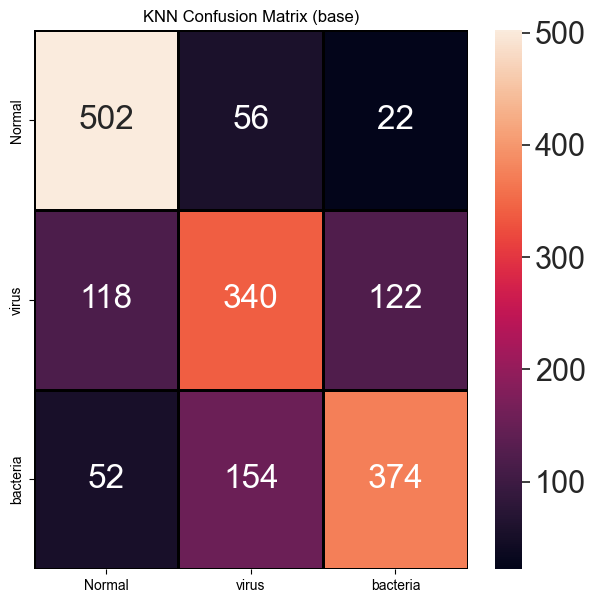

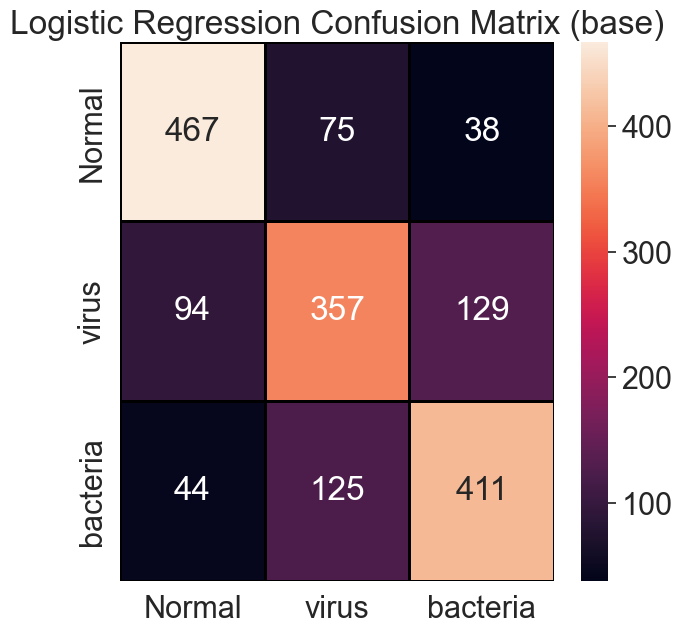

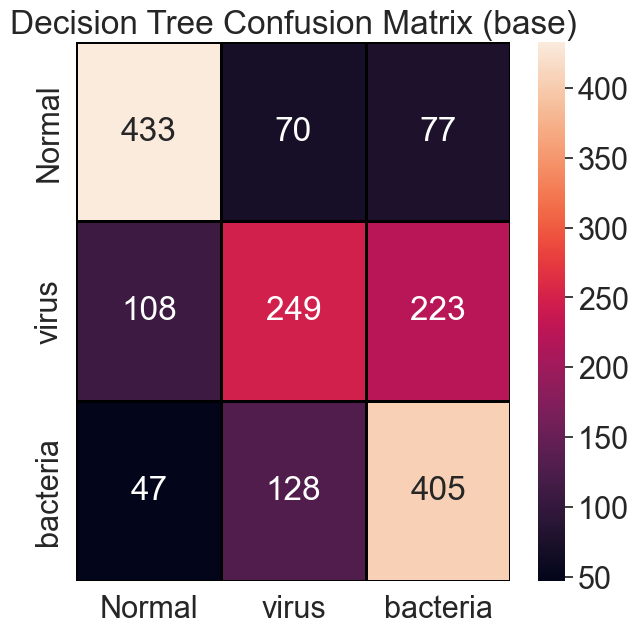

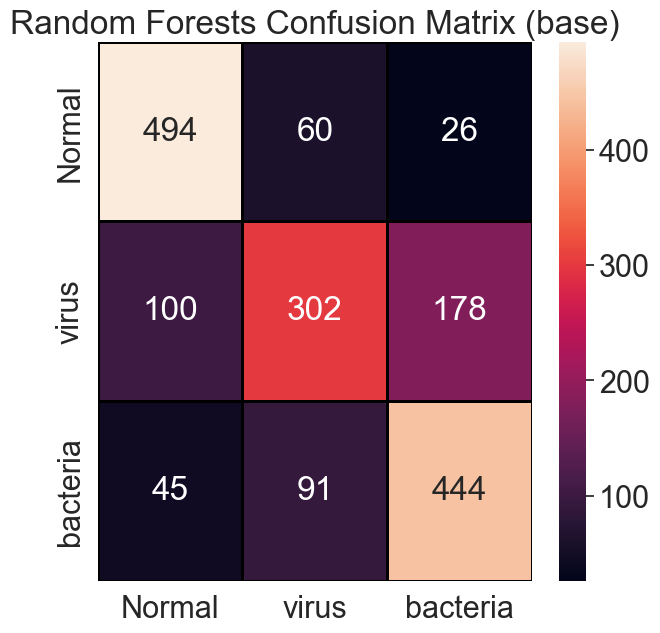

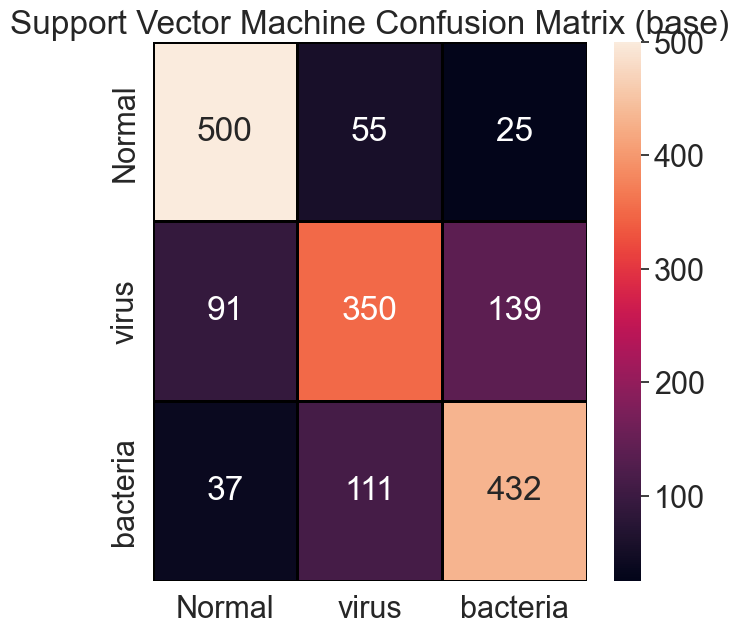

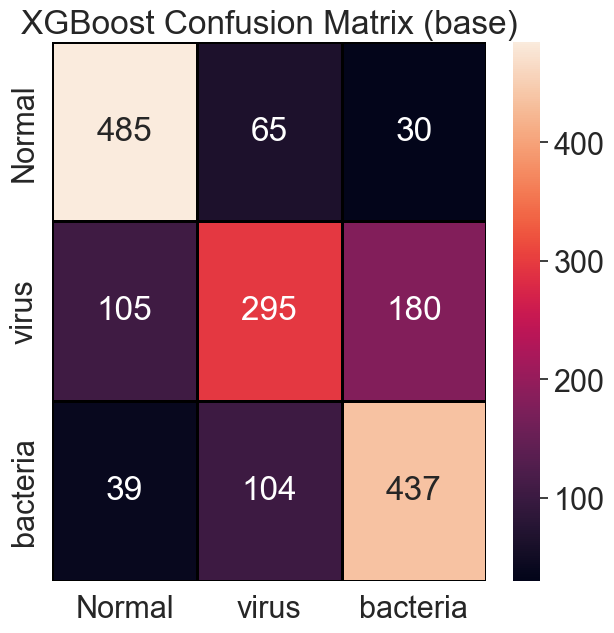

In [14]:
#plot confusion matrix for each model
plot_cm(knn_predicted, y_test, 'KNN Confusion Matrix (base)')
plot_cm(log_reg_predicted, y_test, 'Logistic Regression Confusion Matrix (base)') 
plot_cm(dtc_predicted, y_test, 'Decision Tree Confusion Matrix (base)')
plot_cm(rfc_predicted, y_test, 'Random Forests Confusion Matrix (base)')
plot_cm(svm_predicted, y_test, 'Support Vector Machine Confusion Matrix (base)')
plot_cm(xgb_predicted, y_test, 'XGBoost Confusion Matrix (base)')

In [25]:
def classification_report_csv(report, title):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-5]:
        row = {}
        row_data = line.split('      ')
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    dum = lines[6].split('      ')
    row1 = {}
    row1['class'] = dum[0]
    row1['precision'] = ''
    row1['recall'] = ''
    row1['f1_score'] = float(dum[4])
    row1['support'] = float(dum[5])
    report_data.append(row1)
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv('feature_selection_analysis/classification_reports/' + title + '.csv', index = False)

In [26]:
#KNN classification report 
report = classification_report(y_test, knn_predicted, target_names= ['Normal (0)', 'Virus (1)', 'Bacteria (2)'])
classification_report_csv(report,'KNN Classification report (base)')
print(report)

              precision    recall  f1-score   support

  Normal (0)       0.75      0.87      0.80       580
   Virus (1)       0.62      0.59      0.60       580
Bacteria (2)       0.72      0.64      0.68       580

    accuracy                           0.70      1740
   macro avg       0.70      0.70      0.69      1740
weighted avg       0.70      0.70      0.69      1740



In [27]:
#Logistic Regression classification report 
report = classification_report(y_test, log_reg_predicted, target_names= ['Normal (0)', 'Virus (1)', 'Bacteria (2)'])
classification_report_csv(report,'Logistic Regression Classification report (base)')
print(report)

              precision    recall  f1-score   support

  Normal (0)       0.77      0.81      0.79       580
   Virus (1)       0.64      0.62      0.63       580
Bacteria (2)       0.71      0.71      0.71       580

    accuracy                           0.71      1740
   macro avg       0.71      0.71      0.71      1740
weighted avg       0.71      0.71      0.71      1740



In [28]:
#Decision Tree classification report 
report = classification_report(y_test, dtc_predicted, target_names= ['Normal (0)', 'Virus (1)', 'Bacteria (2)'])
classification_report_csv(report,'Decision Tree Classification report (base)')
print(report)

              precision    recall  f1-score   support

  Normal (0)       0.74      0.75      0.74       580
   Virus (1)       0.56      0.43      0.48       580
Bacteria (2)       0.57      0.70      0.63       580

    accuracy                           0.62      1740
   macro avg       0.62      0.62      0.62      1740
weighted avg       0.62      0.62      0.62      1740



In [29]:
#Random Forest classification report 
report = classification_report(y_test, rfc_predicted, target_names= ['Normal (0)', 'Virus (1)', 'Bacteria (2)'])
classification_report_csv(report,'Random Forests Classification report (base)')
print(report)

              precision    recall  f1-score   support

  Normal (0)       0.77      0.85      0.81       580
   Virus (1)       0.67      0.52      0.58       580
Bacteria (2)       0.69      0.77      0.72       580

    accuracy                           0.71      1740
   macro avg       0.71      0.71      0.71      1740
weighted avg       0.71      0.71      0.71      1740



In [30]:
#SVM classification report 
report = classification_report(y_test, svm_predicted, target_names= ['Normal (0)', 'Virus (1)', 'Bacteria (2)'])
classification_report_csv(report,'Support Vector Machine Classification report (base)')
print(report)

              precision    recall  f1-score   support

  Normal (0)       0.80      0.86      0.83       580
   Virus (1)       0.68      0.60      0.64       580
Bacteria (2)       0.72      0.74      0.73       580

    accuracy                           0.74      1740
   macro avg       0.73      0.74      0.73      1740
weighted avg       0.73      0.74      0.73      1740



In [31]:
#XGBoost classification report 
report = classification_report(y_test, xgb_predicted, target_names= ['Normal (0)', 'Virus (1)', 'Bacteria (2)'])
classification_report_csv(report,'XGBoost Classification report (base)')
print(report)

              precision    recall  f1-score   support

  Normal (0)       0.77      0.84      0.80       580
   Virus (1)       0.64      0.51      0.57       580
Bacteria (2)       0.68      0.75      0.71       580

    accuracy                           0.70      1740
   macro avg       0.69      0.70      0.69      1740
weighted avg       0.69      0.70      0.69      1740



## Hyperparameter Tuning

### KNN

In [32]:
#knn tunning
knn_ht = KNeighborsClassifier()
k_range = list(range(1, 20))
param_grid = dict(n_neighbors=k_range)
  
# defining parameter range
grid_knn = GridSearchCV(knn_ht, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search_knn=grid_knn.fit(X_train, y_train)

print(grid_search_knn.best_params_)
accuracy = grid_search_knn.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Fitting 10 folds for each of 19 candidates, totalling 190 fits
{'n_neighbors': 19}
Accuracy for our training dataset with tuning is : 69.62%


Accuracy for our testing dataset with tuning is : 73.33%


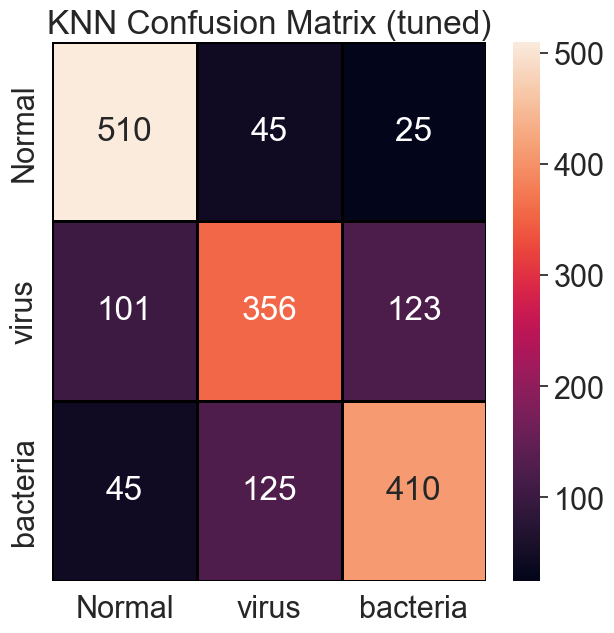

              precision    recall  f1-score   support

  Normal (0)       0.78      0.88      0.83       580
   Virus (1)       0.68      0.61      0.64       580
Bacteria (2)       0.73      0.71      0.72       580

    accuracy                           0.73      1740
   macro avg       0.73      0.73      0.73      1740
weighted avg       0.73      0.73      0.73      1740



In [40]:
best_params_knn = grid_search_knn.best_params_
knn_bm = KNeighborsClassifier(n_neighbors=best_params_knn['n_neighbors'])
knn_bm.fit(X_train, y_train)
y_test_hat=knn_bm.predict(X_test) 
test_accuracy=accuracy_score(y_test,y_test_hat)*100
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )
plot_cm(y_test_hat, y_test, 'KNN Confusion Matrix (tuned)')

report = classification_report(y_test, y_test_hat, target_names= ['Normal (0)', 'Virus (1)', 'Bacteria (2)'])
classification_report_csv(report,'knn Classification report (tuned)')
print(report)

### Logistic Regression

In [36]:
#logistic regression tunning
log_ht = LogisticRegression()
param_grid = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}
 
# defining parameter range
grid_log = GridSearchCV(log_ht, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search_log=grid_log.fit(X_train, y_train)

print(grid_search_log.best_params_)
accuracy = grid_search_log.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Fitting 10 folds for each of 42 candidates, totalling 420 fits
{'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy for our training dataset with tuning is : 68.76%


C:\Users\nccru\anaconda3\envs\gt-oms-isye-6740\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
140 fits failed out of a total of 420.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nccru\anaconda3\envs\gt-oms-isye-6740\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nccru\anaconda3\envs\gt-oms-isye-6740\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\nccru\anaconda3\envs\gt-oms-isye-6740\lib\site-packages\sklearn\linear_model\_logist

Accuracy for our testing dataset with tuning is : 70.57%


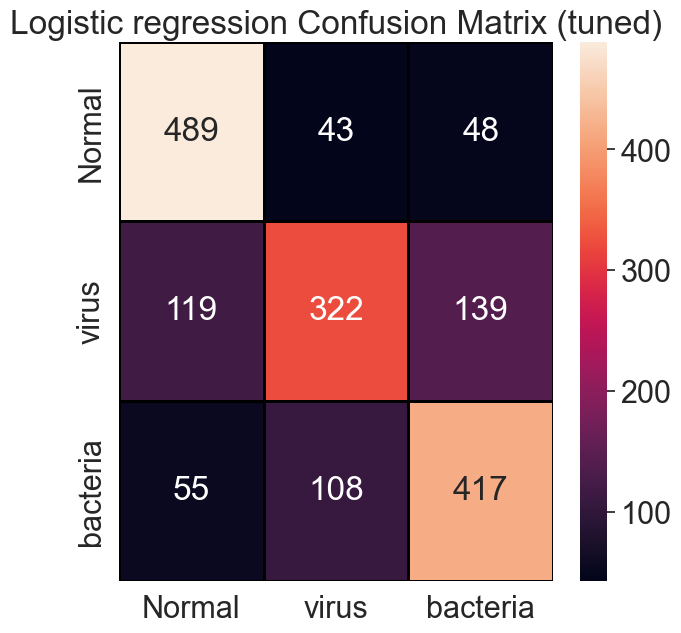

              precision    recall  f1-score   support

  Normal (0)       0.74      0.84      0.79       580
   Virus (1)       0.68      0.56      0.61       580
Bacteria (2)       0.69      0.72      0.70       580

    accuracy                           0.71      1740
   macro avg       0.70      0.71      0.70      1740
weighted avg       0.70      0.71      0.70      1740



In [41]:
best_params_log = grid_search_log.best_params_
log_bm = LogisticRegression(C= best_params_log['C'], 
                            penalty= best_params_log['penalty'], 
                            solver= best_params_log['solver'])
log_bm.fit(X_train, y_train)
y_test_hat=log_bm.predict(X_test) 
test_accuracy=accuracy_score(y_test,y_test_hat)*100
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )
plot_cm(y_test_hat, y_test, 'Logistic regression Confusion Matrix (tuned)')

report = classification_report(y_test, y_test_hat, target_names= ['Normal (0)', 'Virus (1)', 'Bacteria (2)'])
classification_report_csv(report,'Logistic regression Classification report (tuned)')
print(report)

### Decision Tree

In [42]:
#Decision Tree tunning
dtc_ht = DecisionTreeClassifier()
param_grid = {
    'criterion' : ['gini','entropy'],
    'max_depth' : range(1,8),
    'min_samples_split': range(1,8),
    'min_samples_leaf': range(1,5),
}
 
# defining parameter range
grid_dtc = GridSearchCV(dtc_ht, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search_dtc=grid_dtc.fit(X_train, y_train)

print(grid_search_dtc.best_params_)
accuracy = grid_search_dtc.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

Fitting 10 folds for each of 392 candidates, totalling 3920 fits
{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 3}
Accuracy for our training dataset with tuning is : 67.90%


C:\Users\nccru\anaconda3\envs\gt-oms-isye-6740\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
560 fits failed out of a total of 3920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
560 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nccru\anaconda3\envs\gt-oms-isye-6740\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nccru\anaconda3\envs\gt-oms-isye-6740\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\nccru\anaconda3\envs\gt-oms-isye-6740\lib\site-packages\sklearn\base.py", line 637, in _validate_pa

Accuracy for our testing dataset with tuning is : 69.14%


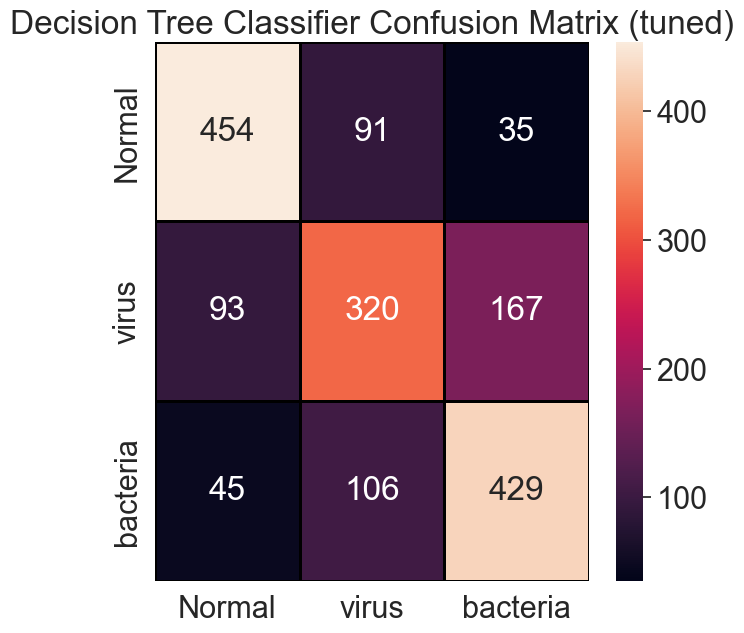

              precision    recall  f1-score   support

  Normal (0)       0.77      0.78      0.77       580
   Virus (1)       0.62      0.55      0.58       580
Bacteria (2)       0.68      0.74      0.71       580

    accuracy                           0.69      1740
   macro avg       0.69      0.69      0.69      1740
weighted avg       0.69      0.69      0.69      1740



In [43]:
best_params_dtc = grid_search_dtc.best_params_
dtc_bm = DecisionTreeClassifier(criterion = best_params_dtc['criterion'], max_depth= best_params_dtc['max_depth'], 
                             min_samples_split= best_params_dtc['min_samples_split'], 
                             min_samples_leaf = best_params_dtc['min_samples_leaf'])
dtc_bm.fit(X_train, y_train)
y_test_hat=dtc_bm.predict(X_test) 
test_accuracy=accuracy_score(y_test,y_test_hat)*100
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )
plot_cm(y_test_hat, y_test, 'Decision Tree Classifier Confusion Matrix (tuned)')

report = classification_report(y_test, y_test_hat, target_names= ['Normal (0)', 'Virus (1)', 'Bacteria (2)'])
classification_report_csv(report,'Decision Tree Classifier Classification report (tuned)')
print(report)

### Random Forest

In [ ]:
# Random forest tunning
rfc_ht = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': range(3,8),
    'min_samples_split': range(3,8),
    'min_samples_leaf': range(1,5),
}

# defining parameter range
grid_rfc = GridSearchCV(rfc_ht, param_grid, cv=10, scoring='accuracy', return_train_score=True,verbose=1)

# fitting the model for grid search
grid_search_rfc=grid_rfc.fit(X_train, y_train)

print(grid_search_rfc.best_params_)
accuracy = grid_search_rfc.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy))

In [ ]:
best_params_rfc = grid_search_rfc.best_params_
rfc_bm = RandomForestClassifier(n_estimators = best_params_rfc['n_estimators'], 
                                max_depth= best_params_rfc['max_depth'], 
                                min_samples_split= best_params_rfc['min_samples_split'], 
                                min_samples_leaf = best_params_rfc['min_samples_leaf'])
rfc_bm.fit(X_train, y_train)
y_test_hat=rfc_bm.predict(X_test) 
test_accuracy=accuracy_score(y_test,y_test_hat)*100
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy))
plot_cm(y_test_hat, y_test, 'Random Forest Classifier Confusion Matrix (tuned)')

report = classification_report(y_test, y_test_hat, target_names= ['Normal (0)', 'Virus (1)', 'Bacteria (2)'])
classification_report_csv(report,'Random Forest Classifier Classification report (tuned)')
print(report)

### SVM

In [ ]:
#SVM tunning
svm_ht = SVC()
param_grid = { 
    'C':[0.1,100,200],
    'kernel':['rbf','poly'],
    # 'degree':[2,3,4,5],
    'degree': [2, 3],
    'gamma': [1, 0.1, 0.01]
    }
# defining parameter range
grid_svm = GridSearchCV(svm_ht, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search_svm=grid_svm.fit(X_train, y_train)

print(grid_search_svm.best_params_)
accuracy = grid_search_svm.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy))

In [ ]:
best_params_svm = grid_search_svm.best_params_
svm_bm = SVC(C = best_params_svm['C'], kernel = best_params_svm['kernel'], 
          degree= best_params_svm['degree'], gamma= best_params_svm['gamma'])
svm_bm.fit(X_train, y_train)
y_test_hat=svm_bm.predict(X_test) 
test_accuracy=accuracy_score(y_test,y_test_hat)*100
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy))
plot_cm(y_test_hat, y_test, 'SVM Classifier Confusion Matrix (tuned)')

report = classification_report(y_test, y_test_hat, target_names= ['Normal (0)', 'Virus (1)', 'Bacteria (2)'])
classification_report_csv(report,'SVM Classifier Classification report (tuned)')
print(report)

### XGBoost

In [ ]:
#XGBoost tunning
xgb_ht = XGBClassifier()
param_grid = {
    'max_depth': range (1, 8),
    'n_estimators': [100, 200, 400],
    'learning_rate': [1, 0.1, 0.05, 0.01]
}
# defining parameter range
grid_xgb = GridSearchCV(xgb_ht, param_grid, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search_xgb=grid_xgb.fit(X_train, y_train)

print(grid_search_xgb.best_params_)
accuracy = grid_search_xgb.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy))

In [ ]:
best_params_xgb = grid_search_xgb.best_params_
xgb_bm = XGBClassifier(max_depth = best_params_xgb['max_depth'], 
                       n_estimators = best_params_xgb['n_estimators'], 
                       learning_rate = best_params_xgb['learning_rate'])
xgb_bm.fit(X_train, y_train)
y_test_hat=xgb_bm.predict(X_test) 
test_accuracy=accuracy_score(y_test,y_test_hat)*100
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy))
plot_cm(y_test_hat, y_test, 'XGBoost Classifier Confusion Matrix (tuned)')

report = classification_report(y_test, y_test_hat, target_names= ['Normal (0)', 'Virus (1)', 'Bacteria (2)'])
classification_report_csv(report,'XGBoost Classifier Classification report (tuned)')
print(report)

## Convolutional Neural Network

In [48]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.random import set_seed
set_seed(123)

In [54]:
# Function to process each row of the dataframe and return a new dataframe
def process_row(row):
    normal = pd.DataFrame({'class': 'normal', 'image_path': row['normal'], 'set': row['set']})
    bacteria = pd.DataFrame({'class': 'bacteria', 'image_path': row['bacteria'], 'set': row['set']})
    virus = pd.DataFrame({'class': 'virus', 'image_path': row['virus'], 'set': row['set']})
    return pd.concat([normal, bacteria, virus], ignore_index=True)

# # Apply the function to each row to create a list of dataframes, then concatenate them
# df = pd.concat(final_df.apply(process_row, axis=1).tolist(), ignore_index=True)

# # Remove rows with empty image_path
# df = df[df['image_path'].apply(lambda x: len(x) > 0)]

# print(df)
df = final_df.copy().drop('Unnamed: 0', axis = 1)
df.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,y,set
0,2.980556,-3.275862,-4.229456,2.637369,4.997620,0.030935,-0.637579,-2.737229,-1.515862,1.247825,...,2.262131,1.716593,-1.203664,-0.265968,-0.150226,-0.174117,1.890962,-1.688081,2,train
1,-6.564300,-4.057967,-6.552143,2.327029,-6.808690,3.417830,-2.390260,-4.471826,-0.473078,-4.866542,...,2.190049,1.391780,-1.850598,0.930205,1.780812,2.484309,1.469409,0.174022,0,train
2,-0.617359,-9.007158,-9.107250,2.815919,4.204915,1.636615,-5.198943,3.210807,-0.030567,-4.537741,...,2.359346,1.464532,0.006303,0.957595,0.568377,-0.521341,-0.036893,-1.370491,0,train
3,-7.003130,-1.783275,5.344337,-4.681501,0.287496,-4.657435,2.194726,-0.011661,4.251541,1.422850,...,1.786465,1.641857,1.541782,-4.641932,-1.166219,0.500252,-0.014694,-1.256362,2,train
4,-14.654309,7.030771,13.029172,0.395497,4.705183,1.842881,-3.591075,5.124075,6.235257,2.200029,...,1.616399,-0.334545,-0.133705,-4.512167,0.141734,5.402647,3.840050,4.003119,2,train


In [55]:
train_df = df[df['set']=='train'].copy()
train_df.drop(['set'], axis=1, inplace = True)

In [56]:
test_df = df[df['set']=='test'].copy()
test_df.drop(['set'], axis=1, inplace = True)

In [57]:
val_df = df[df['set']=='validate'].copy()
val_df.drop(['set'], axis=1, inplace = True)

In [59]:
# constants
batch_size = 16
# image_size = (64, 64)
epochs = 50

# CNN model
model = Sequential([
        # keras.Input(shape=(image_size[0], image_size[1], 3)),
        
        keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        keras.layers.MaxPool2D(),
        
        keras.layers.SeparableConv2D(32, 3, activation='relu', padding='same'),
        keras.layers.SeparableConv2D(32, 3, activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(),
        
        keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
        keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(),
        
        keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
        keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(),
        keras.layers.Dropout(0.2),
        
        keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
        keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(),
        keras.layers.Dropout(0.2),
        
        keras.layers.Flatten(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.7),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        
        keras.layers.Dense(3, activation='softmax')  # Three output nodes for three classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])  # Use categorical cross-entropy as the loss function

# # generators to read images from dataset directories
# train_datagen = ImageDataGenerator(rescale=1./255)
# test_datagen = ImageDataGenerator(rescale=1./255)

# train_generator = train_datagen.flow_from_dataframe(train_df, x_col='image_path', y_col='class', target_size=image_size, batch_size=batch_size)
# validation_generator = train_datagen.flow_from_dataframe(val_df, x_col='image_path', y_col='class', target_size=image_size, batch_size=batch_size)
# test_generator = test_datagen.flow_from_dataframe(test_df, x_col='image_path', y_col='class', target_size=image_size, batch_size=batch_size)

# callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=5)
# model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
# reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Train the model
history = model.fit(
    train_df,
    validation_data=val_df,
    epochs=epochs,
#    callbacks=[early_stopping, model_checkpoint, reduce_lr_on_plateau]
)

# Evaluate the model
loss, accuracy = model.evaluate(test_df)
print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}')

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().